In [10]:
import qiskit as qk
from qiskit.primitives import Sampler
from matplotlib.pyplot import show
from numpy import pi

In [2]:
def run_circuit(circuit_function):
    def wrapper(*args, **kwargs):
        circuit = circuit_function(*args, **kwargs)
        sampler = Sampler()
        job = sampler.run(circuits=[circuit])
        result = job.result()
        return result
    return wrapper

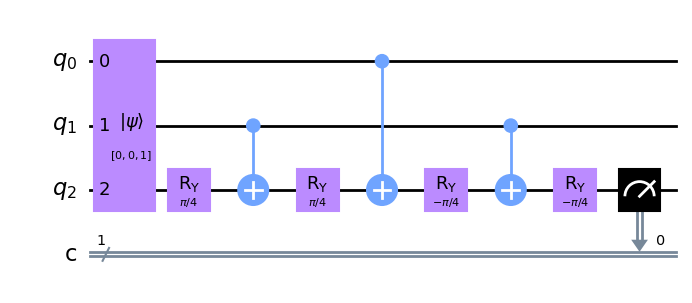

In [38]:
def Margolus(x=0, y=0, z=0):
    circuit = qk.QuantumCircuit(3, 1)
    circuit.initialize(f"{x}{y}{z}")
    circuit.ry(pi/4, 2)
    circuit.cx(1, 2)
    circuit.ry(pi/4, 2)
    circuit.cx(0, 2)
    circuit.ry(-pi/4, 2)
    circuit.cx(1, 2)
    circuit.ry(-pi/4, 2)
    circuit.measure(2, 0)
    return circuit

example = Margolus(z=1)
Margolus = run_circuit(Margolus)
example.draw(output="mpl", style="clifford")

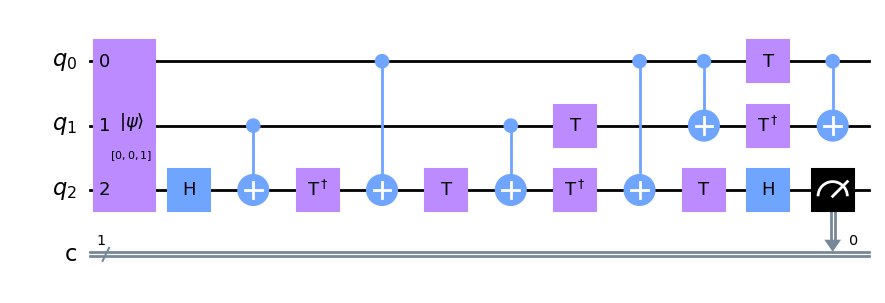

In [35]:
def Toffoli(x=0, y=0, z=0):
    circuit = qk.QuantumCircuit(3, 1)
    circuit.initialize(f"{x}{y}{z}")
    circuit.h(2)
    circuit.cx(1, 2)
    circuit.tdg(2)
    circuit.cx(0, 2)
    circuit.t(2)
    circuit.cx(1, 2)
    circuit.tdg(2)
    circuit.cx(0, 2)
    circuit.t([1, 2])
    circuit.h(2)
    circuit.cx(0, 1)
    circuit.tdg(1)
    circuit.t(0)
    circuit.cx(0, 1)
    circuit.measure(2, 0)
    return circuit

example = Toffoli()
Toffoli = run_circuit(Toffoli)
example.draw(output="mpl", style="clifford")

In [46]:
for x in [0, 1]:
    for y in [0, 1]:
        for z in [0, 1]:
            res_margolus = Margolus(x, y, z).quasi_dists[0].keys()
            res_toffoli = Toffoli(x, y, z).quasi_dists[0].keys()
            print(f"Expected answer for CCX({x},{y},{z}) is", (x & y) ^ z,"\n", 
                  "Margolus:", *res_margolus, "\n", 
                  "Toffoli:", *res_toffoli)

Expected answer for CCX(0,0,0) is 0 
 Margolus: 0 
 Toffoli: 0
Expected answer for CCX(0,0,1) is 1 
 Margolus: 0 
 Toffoli: 0
Expected answer for CCX(0,1,0) is 0 
 Margolus: 0 
 Toffoli: 0
Expected answer for CCX(0,1,1) is 1 
 Margolus: 1 
 Toffoli: 1
Expected answer for CCX(1,0,0) is 0 
 Margolus: 1 
 Toffoli: 1
Expected answer for CCX(1,0,1) is 1 
 Margolus: 1 
 Toffoli: 1
Expected answer for CCX(1,1,0) is 1 
 Margolus: 1 
 Toffoli: 1
Expected answer for CCX(1,1,1) is 0 
 Margolus: 0 
 Toffoli: 0


# Adder

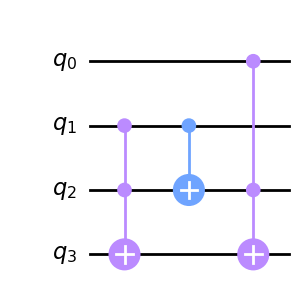

In [81]:
CarryGate = qk.QuantumCircuit(4, name="Carry")
CarryGate.ccx(1, 2, 3)
CarryGate.cx(1, 2)
CarryGate.ccx(0, 2, 3)
CarryGate.draw(output="mpl", style="clifford")

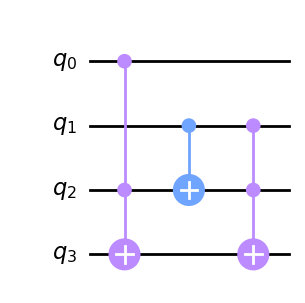

In [243]:
InverseCarryGate = qk.QuantumCircuit(4, name="InverseCarry")
InverseCarryGate.ccx(0, 2, 3)
InverseCarryGate.cx(1, 2)
InverseCarryGate.ccx(1, 2, 3)
InverseCarryGate.draw(output="mpl", style="clifford")

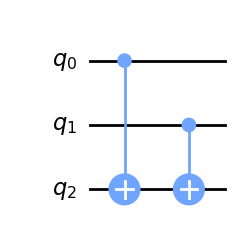

In [82]:
SumGate = qk.QuantumCircuit(3, name="Sum")
SumGate.cx(0, 2)
SumGate.cx(1, 2)
SumGate.draw(output="mpl", style="clifford")

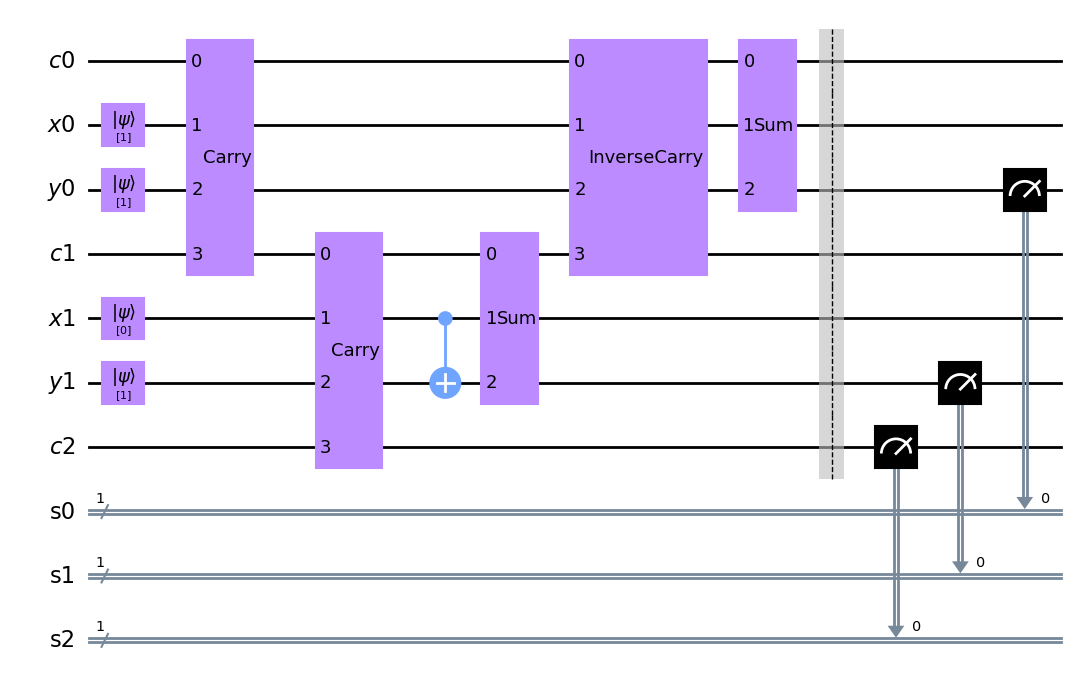

In [275]:
# @run_circuit
def add(x, y):
    global CarryGate, InverseCarryGate, SumGate
    assert 0 <= x <= 3 and 0 <= y <= 3, "Invalid input"
    # Preprocessing
    x, y = map(lambda x: bin(x)[2:], [x, y])
    x = "0" * (2 - len(x)) + x
    y = "0" * (2 - len(y)) + y

    # Initaliztion
    c0, c1, c2 = qk.QuantumRegister(1, name="c0"), qk.QuantumRegister(1, name="c1"), qk.QuantumRegister(1, name="c2")
    x0, x1 = qk.QuantumRegister(1, name="x0"), qk.QuantumRegister(1, name="x1")
    y0, y1 = qk.QuantumRegister(1, name="y0"), qk.QuantumRegister(1, name="y1")
    s0, s1, s2 = qk.ClassicalRegister(1, name="s0"), qk.ClassicalRegister(1, name="s1"), qk.ClassicalRegister(1, name="s2")

    circuit = qk.QuantumCircuit(c0, x0, y0, c1, x1, y1, c2, s0, s1, s2)

    circuit.initialize(x[1], x0)
    circuit.initialize(x[0], x1)
    circuit.initialize(y[1], y0)
    circuit.initialize(y[0], y1)

    # Circuit itself
    circuit.append(CarryGate, [c0, x0, y0, c1])
    circuit.append(CarryGate, [c1, x1, y1, c2])
    circuit.cx(x1, y1)
    circuit.append(SumGate, [c1, x1, y1])
    circuit.append(InverseCarryGate, [c0, x0, y0, c1])
    circuit.append(SumGate, [c0, x0, y0])
    circuit.barrier()
    circuit.measure([c2[0], y1[0], y0[0]], [s2[0], s1[0], s0[0]])
    return circuit

add(1, 3).draw(output="mpl", style="clifford")

In [276]:
add = run_circuit(add)

In [277]:
for x in range(4):
    for y in range(4):
        print("Real answer", x + y, "Computed", *add(x, y).quasi_dists[0])

Real answer 0 Computed 0
Real answer 1 Computed 1
Real answer 2 Computed 2
Real answer 3 Computed 3
Real answer 1 Computed 1
Real answer 2 Computed 2
Real answer 3 Computed 3
Real answer 4 Computed 4
Real answer 2 Computed 2
Real answer 3 Computed 3
Real answer 4 Computed 4
Real answer 5 Computed 5
Real answer 3 Computed 3
Real answer 4 Computed 4
Real answer 5 Computed 5
Real answer 6 Computed 6
